Mask so far is not that effective. Yellow was largely ignored and green is very liberal taking up blue shades as well, confusing yellow signals. So here we will try to randomly select images in each of labels (unlike 1 in 11xx images), and tune our mask performance. 

Below is static code snippet, so can be used to check for one set at once.

**Layout:**

In [1]:
# thank you: https://github.com/foutaise/texttable/
from texttable import Texttable
table = Texttable()
table_cells = []
for i in range(0,3): #0,1,2

    labels = ['Red Signal', 'Yellow Signal', 'Green Signal']
    cols = [ labels[i],  'redmask', 'yellowmask', 'greenmask' ]
        
    each_row = []
    for j in range(0,4): # 0,1,2,3
        each_row.append(cols[j] + '({},{})'.format(i,j))
        
    table_cells.append(each_row)
    
table.add_rows(table_cells)
print(table.draw() + '\n')

+--------------------+--------------+-----------------+----------------+
|  Red Signal(0,0)   | redmask(0,1) | yellowmask(0,2) | greenmask(0,3) |
+====================+==============+=================+================+
| Yellow Signal(1,0) | redmask(1,1) | yellowmask(1,2) | greenmask(1,3) |
+--------------------+--------------+-----------------+----------------+
| Green Signal(2,0)  | redmask(2,1) | yellowmask(2,2) | greenmask(2,3) |
+--------------------+--------------+-----------------+----------------+



**Code:**

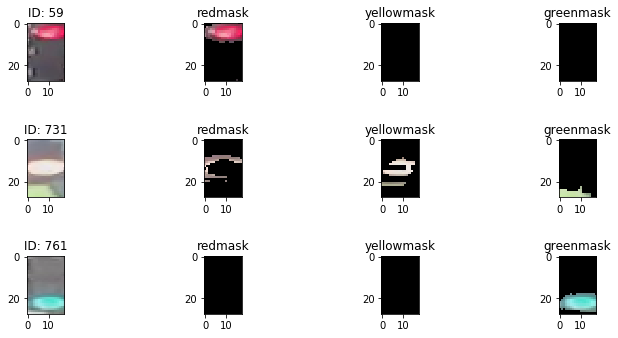

In [42]:
%matplotlib inline 

from IPython.display import Image, display, HTML
from loaders import STANDARDIZED_LIST
import matplotlib.pyplot as plt
from matplotlib import animation
import cv2
import numpy as np
from random import randint



nrows = 3
ncols = 4   
f, axArray = plt.subplots(nrows, ncols, figsize=(10,5))  
f.tight_layout()
plt.subplots_adjust(bottom=0.15, hspace=1)

def getSeparateLists(image_list):
    """
    Assuming list is standardized and having label attached to identify, 
    we will create 3 separate lists and send.
    NOTE LABEL STRIPPED AND ID ATTACHED
    """
    red_images = []    
    yellow_images = []
    green_images = []
    for index, each_image_label_pair in enumerate(image_list):  
        image = each_image_label_pair[0]
        label = each_image_label_pair[1]
        if label[0] == 1:
            red_images.append((image, index))
        elif label[1] == 1:
            yellow_images.append((image,index))
        else:
            green_images.append((image,index))
    #print('Red list length: {}  Yellow list length: {}'.format(len(red_images),len(yellow_images)))
    return (red_images,yellow_images,green_images)

def getMaskedImage(image, label):
    """
    Returns the masked image as per label specified. For eg, label as 'Red' would 
    result in red areas extracted out of incoming image, and resultant image returned.
    NOTE INCOMING IMAGE IS RGB (if you used cv.imread,it would be BGR. I used matplotlib imread)
    """
    # first convert to HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    if label is 'red':
        red_mask_hsv1 = cv2.inRange(image_hsv, (0,30,50), (10,255,255))
        red_mask_hsv2 = cv2.inRange(image_hsv, (150,40,50), (180,255,255))
        mask_hsv = cv2.bitwise_or(red_mask_hsv1,red_mask_hsv2)
    elif label is 'yellow':
        mask_hsv = cv2.inRange(image_hsv, (10,10,110),(31,255,255))   
    else: # green
        mask_hsv = cv2.inRange(image_hsv,(43,40,120),(95,255,255)) 
        
    # standard mask operations to extract out specified label color
    mask_hsv = cv2.bitwise_not(mask_hsv)  # invert the mask
    masked_image = np.copy(image)
    masked_image[mask_hsv != 0] = [0, 0, 0] 
    
    return masked_image

def getHSVSum(image):
    """
    Input: RGB image (ensure, its not BGR)
    Output: HSV sums individually
    """
    # first convert to HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # HSV channels
    h = image_hsv[:,:,0]
    s = image_hsv[:,:,1]
    v = image_hsv[:,:,2]
    h_sum = np.sum(h[:,:],axis=1)
    s_sum = np.sum(s[:,:],axis=1)
    v_sum = np.sum(v[:,:],axis=1)    
    
    return (h_sum, s_sum, v_sum)


# 723 to 757 is yellow 
def snapshot(): # just a placeholder instead of 'animate' later

    # NOTE: change this every time to test a set of R,Y,G signals
    r_index = 59
    y_index = 731
    g_index = 761
    len_RList = len(STANDARDIZED_DIVIDED_LIST[0]) #red
    len_YList = len(STANDARDIZED_DIVIDED_LIST[1]) #yellow
    index_in_focus = [r_index,y_index-len_RList,g_index-(len_RList+len_YList)]    
    
    [axArray[i,j].clear() for i in range(0,nrows) for j in range(0,ncols)] 
    #[axArray[i,j].set_ylim([0,6000]) for i in range(0,nrows) for j in range(1,ncols)]    
    axArray[0,1].set_title('red mask')
    axArray[0,2].set_title('yellow mask')
    axArray[0,3].set_title('green mask')    
        
    
    # each label type would form 1 rows with 4 cols each
    # so below for loop is going to iterate 3 times, that is 'k' = 0,1,2
    nrows_1 = 1 # per image or per label 1 rows.         
    for k, each_list in enumerate(STANDARDIZED_DIVIDED_LIST):  
    
        #print(k, len(each_list))
    
        # get the image      
        num = index_in_focus[k]   # NOTE: as specified in index_in_focus
        image = each_list[num][0]
        index = each_list[num][1]
    
        # crop it
        image = image[2:-2, 7:-7, :]    

        # area (note we are taking it after crop)
        (width,height,_) = image.shape
        area = width*height           
    
        # initialize axes
        axArray[k*nrows_1,0].set_title('ID: {}'.format(index))  
        
        # show original image
        #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        #blur_kernel = np.ones((5,5),np.float32)/25
        #blurred_gray = cv2.filter2D(gray,-1,blur_kernel)        
        #kernel = np.array([[ 0, -1, 0], 
        #                   [ -1, 4, -1], 
        #                   [ 0, -1, 0]])       
        #filtered_image = cv2.filter2D(image, -1, kernel)
        #axArray[k*nrows_1,0].imshow(filtered_image)
        axArray[k*nrows_1,0].imshow(image)
               
        labels = ['red', 'yellow', 'green']

        for j in range(1,4):
            label = labels[j-1]
            masked_image = getMaskedImage(image,label)        # masked image
            axArray[k,j].set_title(label + 'mask')    
            axArray[k,j].imshow(masked_image, cmap='gray')    
        
    
                    
STANDARDIZED_DIVIDED_LIST = getSeparateLists(STANDARDIZED_LIST)
snap = snapshot()

#plt.close()
#HTML(anim.to_html5_video())